Assignment 2 made by:

Niels van den Hork - s4572602

Niels van Drueten - s4496604



In [3]:
from scipy.io import loadmat
from scipy import signal
import numpy as np
import json
import matplotlib.pyplot as plt
#!pip install tqdm
from tqdm import tqdm_notebook as tqdm #if running in a notebook
#from tqdm import tqdm as tqdm #if not running in a notebook
from scipy.stats.stats import pearsonr
#from numpy import correlate as corr #not pearson 


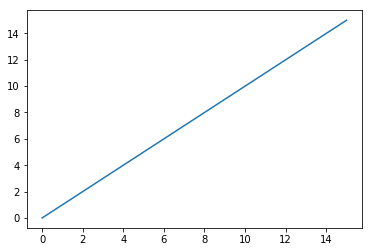

In [4]:
# PRESENT Cipher SBox
SBox = [0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2]
SBox_inv = [0x5, 0xE, 0xF, 0x8, 0xC, 0x1, 0x2, 0xD, 0xB, 0x4, 0x6, 0x3, 0x0, 0x7, 0x9, 0xA]

assert(SBox[SBox_inv[0]] == 0)
assert(SBox[SBox_inv[5]] == 5)
assert(SBox[SBox_inv[7]] == 7)
assert(SBox[SBox_inv[0xD]] == 0xD)
plt.plot([SBox[SBox_inv[x]] for x in range(16)]) #sanity checks
plt.show()

# Function f is the intermediate result,
# where i is the known non-constant data value
# and k is a small part of the key.
def f(i, k):
    i1, i2 = i >> 4, i & 0x0F
    k1, k2 = k >> 4, k & 0x0F
    inv1, inv2 = SBox[i1] ^ k1, SBox[i2] ^ k2
    result = inv1 << 4 ^ inv2
    return result

# Function f_inv is the inverse of intermediate result,
# where o is the known non-constant data value
# and k is a small part of the key.
def f_inv(o, k):
    o1, o2 = o >> 4, o & 0x0F
    k1, k2 = k >> 4, k & 0x0F
    inv1, inv2 = SBox_inv[o1] ^ k1, SBox_inv[o2] ^ k2
    result = inv1 << 4 ^ inv2
    return result

# Returns the Hamming distance between val1 and val2.
def hd(val1,val2):
    return bin(val1 ^ val2).count("1")

assert(hd(0b1001,0b1011) == 1) #sanity checks
assert(hd(0b1111,0b1001) == 2)
assert(hd(0b1111,0b1111) == 0)
assert(hd(0b0000,0b1111) == 4)
assert(hd(0b00001111,0b11110000) == 8)


In [5]:
def construct_input_matrix(output, key_len):
	input = np.zeros((len(output), 2**key_len), dtype="uint8")
	for i in range(len(output)):
		output_elem = output[i][0]
		for k in range(2**key_len):
			val = f_inv(output_elem,k)
			input[i][k] = val
	return input

In [6]:
# Returns a Value-Prediction Matrix of size [no_inputs x no_keys]
# Input _in: Input matrix variable of size [no_inputs]
def construct_val_pred_matrix(_in, key_len):
	output = np.zeros((len(_in), 2**key_len), dtype="uint8")
	for i in range(len(_in)):
		in_elem = _in[i][0]
		for k in range(2**key_len):
			val = f_inv(in_elem,k)
			output[i][k] = val
	return output	

# Returns a Power-Prediction Matrix of size [no_inputs x no_keys]
# Input _in: Value-Prediction Matrix of size [no_inputs x no_keys]
def construct_pow_pred_matrix(val_pred_matrix, od, key_len):
	output = np.zeros((len(_in), 2**key_len), dtype="uint8")
	for i in range(len(_in)):
		in_elem = _in[i][0]
		for k in range(2**key_len):
			val1 = val_pred_matrix[i][k]
			val2 = od[i][0]
			output[i][k] = hd(val1, val2)
	return output

In [7]:
# Uses the correlate function of the scipy io library,
# that cross-correlates two matrices.

def correlate_m(matrix1, matrix2):
    print(matrix1.shape,matrix2.shape)
    
    cols_matrix1 = matrix1.shape[1]
    cols_matrix2 = matrix2.shape[1]
    
    result = np.zeros((cols_matrix1,cols_matrix2))
    
    for j in tqdm(range(cols_matrix2)):
        for i in range(cols_matrix1):
            #result[i][j] = pearsonr(matrix1[:,i], matrix2[:,j])[0]
            result[i][j] = np.corrcoef(matrix1[:,i], matrix2[:,j])[0][1]
    return result


In [8]:
#unused?
def sort_correlation(correlation):
	return list(sorted(correlation,key= lambda x: x[0][0]))


Here we load the traceset. There are 11 peaks as you would expect from AES. All traces are similar to eachother.

Input: 
 [[-54. -54. -51. ...  20.  22.  23.]
 [-56. -56. -52. ...  19.  22.  21.]
 [-42. -42. -49. ...  21.  20.  23.]
 ...
 [-54. -54. -51. ...  22.  21.  23.]
 [-56. -56. -52. ...  19.  21.  24.]
 [-45. -45. -48. ...  21.  22.  22.]] (10000, 2000)


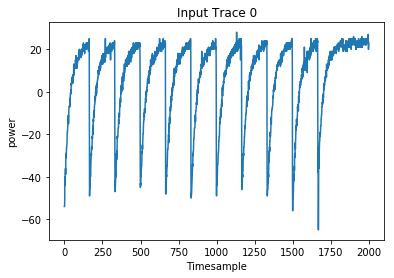

In [9]:
# Opens "hardware_traces.mat" file.
ht_file = loadmat('hardware_traces.mat')
ht = ht_file['traces'] #contains 10.000 traces, 2k samples each, 8bit(?) values

print("Input: \n {} {}".format(ht, ht.shape))

plt.plot(ht[0])
plt.title('Input Trace 0')
plt.xlabel('Timesample')
plt.ylabel('power')
plt.show()

Input: 
 [216  95 100 ... 207 235  72] (10000, 1)


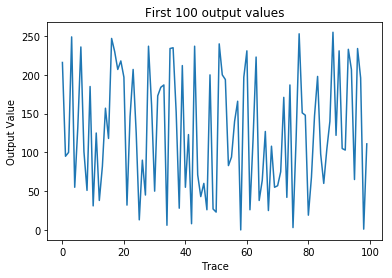

In [10]:
# Opens "output_data.mat" file.
od_file = loadmat('output_data.mat')
od = od_file['output_data'] #contains 10.000 output values, each 8bit

print("Input: \n {} {}".format(od[:,0], od.shape))

plt.plot(od[:100,0])
plt.title('First 100 output values')
plt.xlabel('Trace')
plt.ylabel('Output Value')
plt.show()

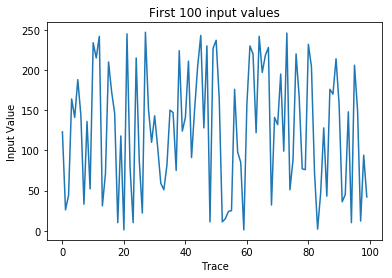

In [11]:
_in = construct_input_matrix(od, 8)
plt.plot(_in[:100,0])
plt.title('First 100 input values')
plt.xlabel('Trace')
plt.ylabel('Input Value')
plt.show()

Here we compute the power consumption that each (output value, key) pair would produce.
Instead of using an input value, like last time, we use the output value And this time these values are 8bit

Value prediction matrix: 
 [[211 210 209 ...  46  45  44]
 [230 231 228 ...  27  24  25]
 [240 241 242 ...  13  14  15]
 ...
 [ 86  87  84 ... 171 168 169]
 [ 72  73  74 ... 181 182 183]
 [  3   2   1 ... 254 253 252]] (10000, 256)
Power prediction matrix: 
 [[3 2 2 ... 6 6 5]
 [5 4 6 ... 2 4 3]
 [3 4 4 ... 4 4 5]
 ...
 [4 3 5 ... 3 5 4]
 [4 3 3 ... 5 5 4]
 [4 3 3 ... 5 5 4]] (10000, 256)


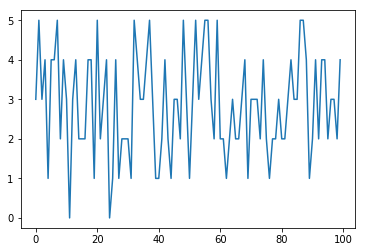

In [12]:
# Computing value prediction matrix
val_pred_matrix = construct_val_pred_matrix(_in, 8)
print("Value prediction matrix: \n {} {}".format(val_pred_matrix, val_pred_matrix.shape))


# Computing power prediction matrix
pow_pred_matrix = construct_pow_pred_matrix(val_pred_matrix, od, 8)
print("Power prediction matrix: \n {} {}".format(pow_pred_matrix, pow_pred_matrix.shape))

plt.plot(pow_pred_matrix[:100,0]) #first 100 input power for the first key (0)

Traces matrix: 
 [[-54. -54. -51. ...  20.  22.  23.]
 [-56. -56. -52. ...  19.  22.  21.]
 [-42. -42. -49. ...  21.  20.  23.]
 ...
 [-54. -54. -51. ...  22.  21.  23.]
 [-56. -56. -52. ...  19.  21.  24.]
 [-45. -45. -48. ...  21.  22.  22.]] (10000, 2000)


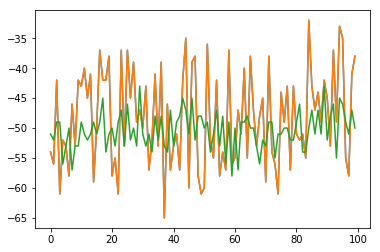

In [13]:
# Opens "traces.mat" file.
trace_file = loadmat('hardware_traces.mat')
_traces = trace_file['traces']
print("Traces matrix: \n {} {}".format(_traces, _traces.shape ))

plt.plot(_traces[:100,0])
plt.plot(_traces[:100,1])
plt.plot(_traces[:100,2])

In [14]:
result = correlate_m(pow_pred_matrix, _traces)
print(result.shape)

(10000, 256) (10000, 2000)



(256, 2000)


In [64]:
def compute_best_key(result):
    key = 0
    value = 0
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            this_value = result[i][j]
            if(this_value > value):
                value = this_value
                key = i
    return key, value

best_keyguess, value = compute_best_key(result)
print("Best key: {} with absolute value: {}".format(key, value))

Best key: 2 with absolute value: 0.04837817924447629


Text(0, 0.5, 'summed absolute correlation')

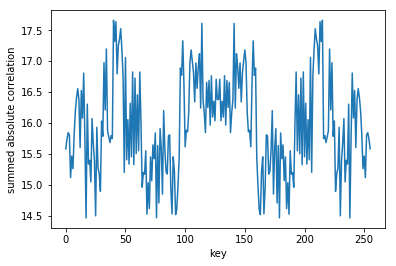

In [65]:
plt.plot([sum(list(map(abs,row))) for row in result])
plt.xlabel('key')
plt.ylabel('summed absolute correlation')

[2.00000000e+00 2.14000000e+02 4.83781792e-02]
[2.53000000e+02 2.14000000e+02 4.83781792e-02]
[1.00000000e+02 7.30000000e+02 4.51770707e-02]
[1.55000000e+02 7.30000000e+02 4.51770707e-02]
[3.60000000e+01 7.30000000e+02 4.38605379e-02]
[2.19000000e+02 7.30000000e+02 4.38605379e-02]
[1.14000000e+02 1.06600000e+03 4.29375947e-02]
[1.41000000e+02 1.06600000e+03 4.29375947e-02]
[9.80000000e+01 1.06600000e+03 4.27191968e-02]
[1.57000000e+02 1.06600000e+03 4.27191968e-02]
[2.22000000e+02 1.34200000e+03 4.18560027e-02]
[3.30000000e+01 1.34200000e+03 4.18560027e-02]
[2.4900000e+02 2.1400000e+02 4.1356242e-02]
[6.0000000e+00 2.1400000e+02 4.1356242e-02]
[1.60000000e+01 2.58000000e+02 4.07219611e-02]
[2.39000000e+02 2.58000000e+02 4.07219611e-02]
[4.00000000e+00 7.30000000e+02 4.07141731e-02]
[2.51000000e+02 7.30000000e+02 4.07141731e-02]
[2.05000000e+02 7.40000000e+01 4.06055723e-02]
[5.00000000e+01 7.40000000e+01 4.06055723e-02]
[6.60000000e+01 2.14000000e+02 4.05079797e-02]
[1.89000000e+02 2.1

Text(0, 0.5, 'peak absolute correlation')

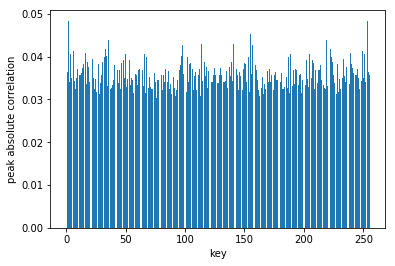

In [66]:
absresult = np.array([list(map(abs,row)) for row in result])
maxidx = np.argmax(absresult,axis=1)

maxconf = np.array([(row[0],midx,row[1][midx]) for row,midx in zip(enumerate(absresult),maxidx)])
smaxconf = np.array(sorted(maxconf,key = lambda x : -x[2]) )

[print(e) for e in smaxconf]
    
plt.bar(range(256),maxconf[:,2] )
plt.xlabel('key')
plt.ylabel('peak absolute correlation')

Text(0, 0.5, 'absolute correlation')

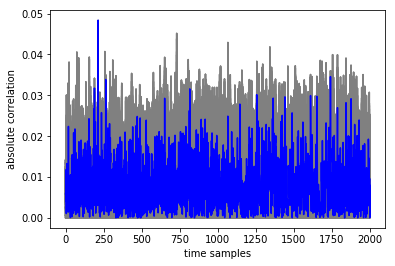

In [67]:
for i,row in enumerate(result):
    if i == best_keyguess:
        continue
    plt.plot(list(map(abs,row)),color='gray')
    
plt.plot(list(map(abs,result[best_keyguess])),color='blue')
plt.xlabel('time samples')
plt.ylabel('absolute correlation')

In [68]:
keyranking = []
for amount in [500,1000,2000,4000,8000,12000]:
    result = correlate_m(pow_pred_matrix[:amount], _traces[:amount])
    
    absresult = np.array([list(map(abs,row)) for row in result])
    maxidx = np.argmax(absresult,axis=1)

    maxconf = np.array([(row[0],midx,row[1][midx]) for row,midx in zip(enumerate(absresult),maxidx)])
    smaxconf = np.array(sorted(maxconf,key = lambda x : -x[2]) )
    #[print(e) for e in smaxconf]
    
    keyrank = np.array([e[0] for e in smaxconf])
    keyidx = np.where(keyrank == best_keyguess)[0][0]
    print(keyidx)
    keyranking.append(keyidx)



(500, 256) (500, 2000)


89
(1000, 256) (1000, 2000)


108
(2000, 256) (2000, 2000)


17
(4000, 256) (4000, 2000)


184
(8000, 256) (8000, 2000)


12
(10000, 256) (10000, 2000)


0


Text(0, 0.5, 'ranking (lower is better)')

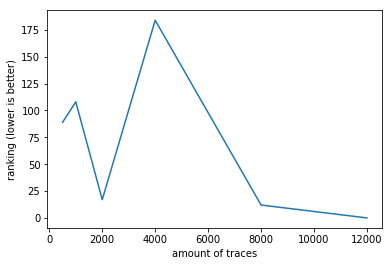

In [69]:
plt.plot(np.array([500,1000,2000,4000,8000,12000]),keyranking)   
plt.xlabel('amount of traces')
plt.ylabel('ranking (lower is better)')